In [1]:
%env OMP_NUM_THREADS=8
%env MKL_NUM_THREADS=8

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

rc_cmufonts = {
    "font.family": "normal",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [], 
    }
fs = 10
font = {'size'   : fs}

mpl.rc('font', **font)
mpl.rcParams.update(rc_cmufonts)
mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from IPython.kernel.zmq.pylab import backend_inline
cfg = backend_inline.InlineBackend.instance()# InlineBackendConfig.instance()
cfg.figure_format = 'svg' # 'png' to switch back

sns.set_context('paper', font_scale=1.5)
sns.set_style('white')
sns.mpl.rcParams['legend.frameon'] = 'False'
#sns.rcParams['legend.frameon'] = 'False'
palette = sns.color_palette() 
fig_format = 'pgf'

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from sklearn.svm import SVC
from sklearn.metrics import hinge_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import copy
import pandas as pd

env: OMP_NUM_THREADS=8
env: MKL_NUM_THREADS=8


/home/hariyuki/apd/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import sys
sys.path.append('../src/')
sys.path.append('../classify/')

In [4]:
data_dirname = '../data/'
data_filename = 'data.npz'
#cv_filename = 'phys_cv_indices_73.npz'
cv_filename = '2phys_cv_indices_73.npz'
eps = 10.*np.spacing(1.)

df = np.load(data_dirname+data_filename)
data, labels = df['data'], df['labels']
data = np.reshape(data, [data.shape[0], -1], order='F')
tmp = np.median(data, axis=0)
ind = np.where(np.abs(tmp) > eps)[0]
data = data[:, ind]

df = np.load(data_dirname+cv_filename)
train_indices, test_indices = df['train_indices'], df['test_indices']

## SVM

In [5]:
Cs = [
    100000, 10000, 1000, 100., 50., 10., 5., 1., 0.75, 0.5, 0.25, 0.01, 0.075,
    0.05, 0.025, 0.001, 0.00075, 0.0005, 0.00025, 0.0001
]

gamma = [0.0001, 0.001, 0.01, 0.1, 1., 10., 100., 'auto']

In [6]:
def check_lambda(
    data, labels, train_indices, test_indices, Cs, gamma='auto',
    kernel='linear', multi_class='ovr', save_filename=None
):
    if (isinstance(gamma, float)) or (gamma == 'auto'):
        gamma = [gamma]
        
    num_iter = len(train_indices)
    uni_labels = np.unique(labels)
    ans = np.zeros((num_iter, len(Cs), len(gamma), 2))
    for k in xrange(num_iter):
        train_index = train_indices[k]
        test_index = test_indices[k]
        
        train_data = [data[train_index, :], labels[train_index]]
        valid_data = [data[test_index, :], labels[test_index]]
        
        meanX = np.median(train_data[0], axis=0, keepdims=True)
        stdX = np.std(train_data[0], axis=0, keepdims=True, ddof=1)
        train_data[0] -= meanX
        train_data[0] /= stdX
        
        valid_data[0] -= meanX
        valid_data[0] /= stdX
        
        for i, C in enumerate(Cs):
            for j, g in enumerate(gamma):
                clf = SVC(
                    C=C,
                    kernel=kernel,
                    degree=3,
                    gamma=g,
                    coef0=0.0,
                    shrinking=True,
                    probability=False,
                    tol=0.001,
                    cache_size=10000,
                    class_weight=None,
                    verbose=False,
                    max_iter=-1,
                    decision_function_shape=multi_class,
                    random_state=None
                )
                clf.fit(train_data[0], train_data[1])

                out_train = clf.decision_function(train_data[0])
                out_valid = clf.decision_function(valid_data[0])

                ans[k, i, j, 0] += hinge_loss(train_data[1], out_train, labels=uni_labels)
                ans[k, i, j, 1] += hinge_loss(valid_data[1], out_valid, labels=uni_labels)
        if save_filename is not None:
            np.savez_compressed(
                save_filename, ans=ans, Cs=Cs, gamma=gamma
            )
    return ans

In [7]:
save_dirname = '../result/'
save_filename = 'check_c_ovr_svm_linear'


ans = check_lambda(
    data, labels, train_indices, test_indices, Cs, gamma='auto', kernel='linear',
    multi_class='ovr', save_filename=save_dirname+save_filename
)

In [8]:
save_dirname = '../result/'
svm1_filename = 'check_c_ovr_svm_linear.npz'
df = np.load(save_dirname+svm1_filename)
ans = np.mean(df['ans'], axis=0)
ind = np.where(ans[:, 0, 1] == ans[:, 0, 1].min())[0]
ind = ind[np.argmin(np.array(Cs)[ind])]
Cb_ovr_svm_linear = Cs[ind]
print('Best linear SVM (ovr): C=%.3f' % (Cb_ovr_svm_linear))

Best linear SVM (ovr): C=0.025


In [21]:
save_filename = 'check_c_ovo_svm_linear'
ans = check_lambda(
    data, labels, train_indices, test_indices, Cs, gamma='auto', kernel='linear',
    multi_class='ovo', save_filename=save_dirname+save_filename
)

In [22]:
save_dirname = '../result/'
svm2_filename = 'check_c_ovo_svm_linear.npz'
df = np.load(save_dirname+svm2_filename)
ans = np.mean(df['ans'], axis=0)
Cb_ovo_svm_linear = Cs[np.argmin(ans[:, 0, 1])]
print('Best linear SVM (ovo): C=%.3e' % (Cb_ovo_svm_linear))

Best linear SVM (ovo): C=2.500e-04


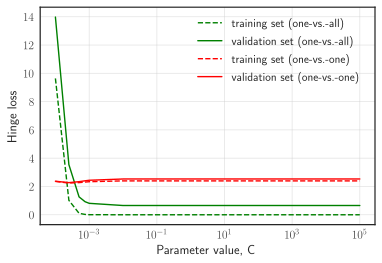

In [13]:
svm1_filename = 'check_c_ovr_svm_linear.npz'
svm2_filename = 'check_c_ovo_svm_linear.npz'

df = np.load(save_dirname+svm1_filename)
svm1_ans = np.mean(df['ans'], axis=0)[:, 0, :]

df = np.load(save_dirname+svm2_filename)
svm2_ans = np.mean(df['ans'], axis=0)[:, 0, :]

ind = np.argsort(Cs)

plt.semilogx(np.array(Cs)[ind], svm1_ans[ind, 0], '--', color='g', label='training set (one-vs.-all)')
plt.semilogx(np.array(Cs)[ind], svm1_ans[ind, 1], '-', color='g', label='validation set (one-vs.-all)')
plt.semilogx(np.array(Cs)[ind], svm2_ans[ind, 0], '--', color='r', label='training set (one-vs.-one)')
plt.semilogx(np.array(Cs)[ind], svm2_ans[ind, 1], '-', color='r', label='validation set (one-vs.-one)')

plt.xlabel('Parameter value, C')
plt.ylabel('Hinge loss')
plt.legend(loc=1)
plt.grid(alpha=0.5)
#plt.ylim(0, 5.0)
plt.show()

In [14]:
save_filename = 'check_c_gamma_ovr_svm_rbf'
ans = check_lambda(
    data, labels, train_indices, test_indices, Cs, gamma, kernel='rbf',
    multi_class='ovr', save_filename=save_dirname+save_filename
)

In [15]:
svm1_filename = 'check_c_gamma_ovr_svm_rbf.npz'
df = np.load(save_dirname+svm1_filename)
ans = np.mean(df['ans'], axis=0)
ind_best = np.where(ans[:, :, 1] == ans[:, :, 1].min())
Cb_ovr_svm_rbf = np.array(Cs)[ind_best[0]][0]
gammab_ovr_svm_rbf = np.array(gamma)[ind_best[1]][0]
print('Best rbf SVM (ovr): C=%.3f, gamma=%s' % (Cb_ovr_svm_rbf, str(gammab_ovr_svm_rbf)))

Best rbf SVM (ovr): C=100.000, gamma=0.0001


In [ ]:
save_dirname = '../result/'
save_filename = 'check_c_gamma_ovo_svm_rbf'
ans = check_lambda(
    data, labels, train_indices, test_indices, Cs, gamma, kernel='rbf',
    multi_class='ovo', save_filename=save_dirname+save_filename
)

In [37]:
svm2_filename = 'check_c_gamma_ovo_svm_rbf.npz'
df = np.load(save_dirname+svm2_filename)
ans = np.mean(df['ans'], axis=0)
ind = np.where(ans[:, 1] == ans[:, 1].min())[0]
ind = ind[np.argmin(np.array(Cs)[ind])]
Cb_ovo_svm_rbf = np.array(Cs)[ind]
gammab_ovo_svm_rbf = np.array(gamma)[ind_best[1][0]]
print('Best rbf SVM (ovo): C=%.3f, gamma=%s' % (Cb_ovo_svm_rbf, str(gammab_ovo_svm_rbf)))

Best rbf SVM (ovo): C=0.500, gamma=0.0001


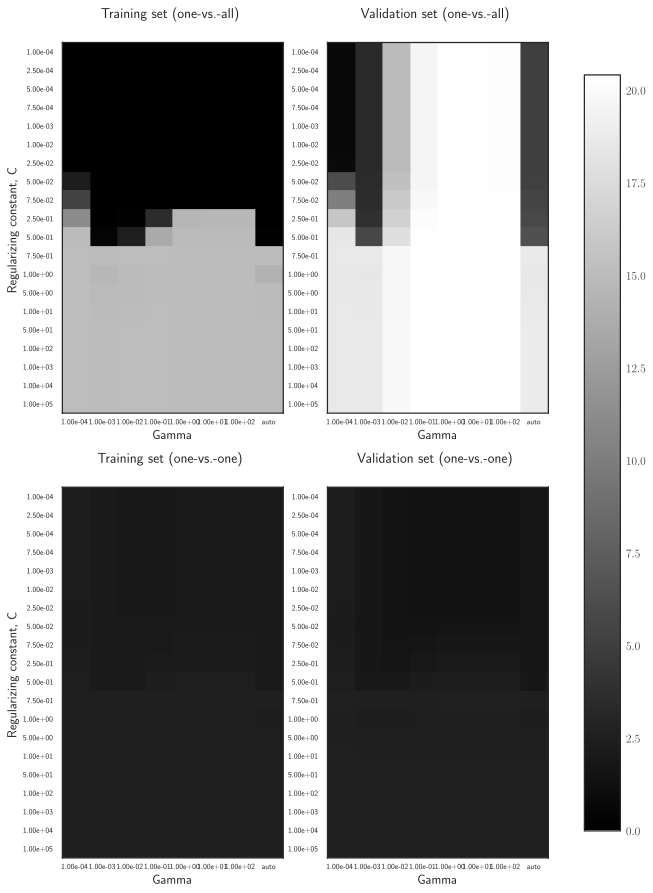

In [48]:
svm1_filename = 'check_c_gamma_ovr_svm_rbf.npz'
svm2_filename = 'check_c_gamma_ovo_svm_rbf.npz'

df = np.load(save_dirname+svm1_filename)
svm1_ans = np.mean(df['ans'], axis=0)

df = np.load(save_dirname+svm2_filename)
svm2_ans = np.mean(df['ans'], axis=0)

ind = np.argsort(Cs)

nrows = 2
ncols = 2

fig, ax = plt.subplots(nrows, ncols, figsize=(10, 15))

xmin = min(svm1_ans.min(), svm2_ans.min())
xmax = max(svm1_ans.max(), svm2_ans.max())

ax[0, 0].matshow(svm1_ans[:, :, 0], aspect='auto', vmin=xmin, vmax=xmax, cmap='gray')
ax[0, 0].set_title('Training set (one-vs.-all)')
#ax[0, 0].set_yticks(gamma)
ax[0, 1].matshow(svm1_ans[:, :, 1], aspect='auto', vmin=xmin, vmax=xmax, cmap='gray')
ax[0, 1].set_title('Validation set (one-vs.-all)')
ax[1, 0].matshow(svm2_ans[:, :, 0], aspect='auto', vmin=xmin, vmax=xmax, cmap='gray')
ax[1, 0].set_title('Training set (one-vs.-one)')
im = ax[1, 1].matshow(svm2_ans[:, :, 1], aspect='auto', vmin=xmin, vmax=xmax, cmap='gray')
ax[1, 1].set_title('Validation set (one-vs.-one)')

for i1 in range(nrows):
    for i2 in range(ncols):
        ax[i1, i2].set_yticks(np.arange(len(Cs)))
        ax[i1, i2].set_yticklabels(
            list(
                map(lambda x: ('%.2e' % (x)), np.array(Cs)[ind])
            ),
            fontsize=8
        )
        if i2 == 0:
            ax[i1, i2].set_ylabel('Regularizing constant, C')

        ax[i1, i2].set_xticks(np.arange(len(gamma)))
        ax[i1, i2].set_xticklabels(
            list(map(lambda x: ('%.2e' % (x)), gamma[:-1]))+[gamma[-1]],
            fontsize=8
        )
        ax[i1, i2].xaxis.set_ticks_position('bottom')
        ax[i1, i2].set_xlabel('Gamma')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

In [38]:
def check_vb(
    data, labels, train_indices, test_indices, Cs, gamma=['auto'], kernel='linear',
    max_samples_per_class=10, random_state=None, save_filename=None, multi_class='ovr'
):
    if random_state is not None:
        np.random.seed(random_state)
    num_iter = len(train_indices)
    ans = np.zeros((num_iter, len(Cs), len(gamma), max_samples_per_class, 2))
    
    uni_labels = np.unique(labels)
    for k_iter in range(num_iter):
        train_index = np.array(train_indices[k_iter])
        test_index = test_indices[k_iter]
        
        current_train_labels = labels[train_index]
        train_labels_n = []
        for k_label in range(len(uni_labels)):
            ind = np.where(current_train_labels == uni_labels[k_label])[0]
            np.random.shuffle(ind)
            ind = ind[:max_samples_per_class]
            train_labels_n.append(train_index[ind])
        
        valid_data = [data[test_index, :], labels[test_index]]
        for n_samples in range(max_samples_per_class):
            ind_train = [x[:n_samples+1].tolist() for x in train_labels_n]
            ind_train = list(reduce(lambda x, y: x+y, ind_train, []))
            ctrain_data = [data[ind_train, :], labels[ind_train]]
            meanX = np.median(ctrain_data[0], axis=0, keepdims=True)
            stdX = np.std(ctrain_data[0], axis=0, keepdims=True, ddof=1)
            ctrain_data[0] -= meanX
            ctrain_data[0] /= stdX
        
            cvalid_data = valid_data[0] - meanX
            cvalid_data /= stdX
            for i, C in enumerate(Cs):
                for j, g in enumerate(gamma):
                    clf = SVC(
                        C=C,
                        kernel=kernel,
                        degree=3,
                        gamma=g,
                        coef0=0.0,
                        shrinking=True,
                        probability=False,
                        tol=0.001,
                        cache_size=10000,
                        class_weight=None,
                        verbose=False,
                        max_iter=-1
                    )
                    
                    clf.fit(ctrain_data[0], ctrain_data[1])

                    out_train = clf.decision_function(ctrain_data[0])
                    out_valid = clf.decision_function(cvalid_data)

                    ans[k_iter, i, j, n_samples, 0] += hinge_loss(
                        ctrain_data[1], out_train, labels=uni_labels
                    )
                    ans[k_iter, i, j, n_samples, 1] += hinge_loss(
                        valid_data[1], out_valid, labels=uni_labels
                    )
        if save_filename is not None:
            np.savez_compressed(
                save_filename, ans=ans, Cs=Cs,
                max_samples_per_class=max_samples_per_class
            )
    return ans


In [39]:
random_state = 198
save_dirname = '../result/'
save_filename = 'check_vb_ovr_svm_linear'
ans1 = check_vb(
    data, labels, train_indices, test_indices, Cs=[Cb_ovr_svm_linear],
    kernel='linear',
    max_samples_per_class=16, random_state=random_state,
    save_filename=save_dirname+save_filename, multi_class='ovr'
)
# unnormalized in file!

In [40]:
random_state = 198
save_dirname = '../result/'
save_filename = 'check_vb_ovr_svm_rbf'
ans1 = check_vb(
    data, labels, train_indices, test_indices, Cs=[Cb_ovr_svm_rbf],
    kernel='rbf', gamma=[float(gammab_ovr_svm_rbf)],
    max_samples_per_class=16, random_state=random_state,
    save_filename=save_dirname+save_filename, multi_class='ovr'
)
# unnormalized in file!

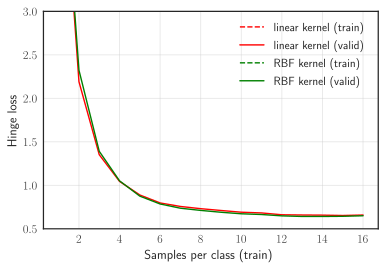

In [47]:
dirname_result = '../result/'
filename_lc_svm_rbf_ovr = 'check_vb_ovr_svm_rbf.npz'
filename_lc_svm_linear_ovr = 'check_vb_ovr_svm_linear.npz'

df = np.load(dirname_result+filename_lc_svm_rbf_ovr)
ans_lc_svm_rbf_ovr = np.mean(df['ans'], axis=0)[0, 0] # len(Cs) = 1, Cs = [Cb]

df = np.load(dirname_result+filename_lc_svm_linear_ovr)
ans_lc_svm_linear_ovr = np.mean(df['ans'], axis=0)[0, 0] # len(Cs) = 1, Cs = [Cb]
#print(df['Cs'])

number_of_observations = 16
number_of_observations = min(number_of_observations, ans_lc_svm_rbf_ovr.shape[0])
#, ans_lc_lr_ovo.shape[0])

t = 1+np.arange(number_of_observations)
ans_lc_svm_rbf_ovr = ans_lc_svm_rbf_ovr[:number_of_observations, :]
ans_lc_svm_linear_ovr = ans_lc_svm_linear_ovr[:number_of_observations, :]

plt.plot(t, ans_lc_svm_linear_ovr[:, 0], '--', color='r', label='linear kernel (train)')
plt.plot(t, ans_lc_svm_linear_ovr[:, 1], '-', color='r', label='linear kernel (valid)')
plt.plot(t, ans_lc_svm_rbf_ovr[:, 0], '--', color='g', label='RBF kernel (train)')
plt.plot(t, ans_lc_svm_rbf_ovr[:, 1], '-', color='g', label='RBF kernel (valid)')

plt.xlabel('Samples per class (train)')
plt.ylabel('Hinge loss')
plt.legend(loc=1)
plt.grid(alpha=0.5)
plt.ylim(0.5, 3.0)
plt.show()

In [9]:
def main_func(
    data, labels, train_indices, test_indices, C, gamma, kernel='linear',
    save_filename=None, multi_class='ovr', scale='standard-median',
    average='macro'
):
    num_iter = len(train_indices)
    uni_labels = np.unique(labels)
    num_classes = len(uni_labels)
    
    recall = np.zeros((num_iter, num_classes+1, 2))
    precision = np.zeros((num_iter, num_classes+1, 2))
    f1 = np.zeros((num_iter, num_classes+1, 2))
    accuracy = np.zeros((num_iter, 2))
    hingeloss = np.zeros((num_iter, 2))
    
    for k_iter in range(num_iter):
        train_index = train_indices[k_iter]
        test_index = test_indices[k_iter]
        
        
        train_data = [data[train_index, :], labels[train_index]]
        valid_data = [data[test_index , :], labels[test_index ]]
        
        if scale.startswith('standard'):
            if scale == 'standard-median':
                meanX = np.median(train_data[0], axis=0, keepdims=True)
            elif scale =='standard-mean':
                meanX = np.mean(train_data[0], axis=0, keepdims=True)
            else:
                raise ValueError
            stdX = np.std(train_data[0], axis=0, keepdims=True, ddof=1)
            train_data[0] -= meanX
            train_data[0] /= stdX

            valid_data[0] -= meanX
            valid_data[0] /= stdX
        elif scale == 'minmax':
            funsc = lambda x: (
                x - x.min(axis=1, keepdims=True)
            ) / (
                x.max(axis=1, keepdims=True) - x.min(axis=1, keepdims=True)
            )
            
            train_data[0] = funsc(train_data[0])
            valid_data[0] = funsc(valid_data[0])
        
        clf = SVC(
            C=C,
            kernel=kernel,
            degree=3,
            gamma=gamma,
            coef0=0.0,
            shrinking=True,
            probability=False,
            tol=0.001,
            cache_size=10000,
            class_weight=None,
            verbose=False,
            max_iter=-1,
            decision_function_shape=multi_class,
            random_state=None
        )
        clf.fit(train_data[0], train_data[1])

        
        out_train = clf.decision_function(train_data[0])
        out_valid = clf.decision_function(valid_data[0])

        hingeloss[k_iter, 0] = hinge_loss(train_data[1], out_train, labels=uni_labels)
        hingeloss[k_iter, 1] = hinge_loss(valid_data[1], out_valid, labels=uni_labels)

        out_train = clf.predict(train_data[0])
        out_valid = clf.predict(valid_data[0])

        accuracy[k_iter, 0] = accuracy_score(train_data[1], out_train)
        accuracy[k_iter, 1] = accuracy_score(valid_data[1], out_valid)
        precision[k_iter, :-1, 0] = precision_score(
            train_data[1], out_train, average=None, labels=uni_labels
        )
        precision[k_iter, -1, 0] = precision_score(
            train_data[1], out_train, average=average, labels=uni_labels
        )
        precision[k_iter, :-1, 1] = precision_score(
            valid_data[1], out_valid, average=None, labels=uni_labels
        )
        precision[k_iter, -1, 1] = precision_score(
            valid_data[1], out_valid, average=average, labels=uni_labels
        )

        recall[k_iter, :-1, 0] = recall_score(
            train_data[1], out_train, average=None, labels=uni_labels
        )
        recall[k_iter, -1, 0] = recall_score(
            train_data[1], out_train, average=average, labels=uni_labels
        )
        recall[k_iter, :-1, 1] = recall_score(
            valid_data[1], out_valid, average=None, labels=uni_labels
        )
        recall[k_iter, -1, 1] = recall_score(
            valid_data[1], out_valid, average=average, labels=uni_labels
        )

        f1[k_iter, :-1, 0] = f1_score(
            train_data[1], out_train, average=None, labels=uni_labels
        )
        f1[k_iter, -1, 0] = f1_score(
            train_data[1], out_train, average=average, labels=uni_labels
        )
        f1[k_iter, :-1, 1] = f1_score(
            valid_data[1], out_valid, average=None, labels=uni_labels
        )
        f1[k_iter, -1, 1] = f1_score(
            valid_data[1], out_valid, average=average, labels=uni_labels
        )

        np.savez_compressed(
            save_filename, accuracy=accuracy, recall=recall, f1=f1,
            precision=precision, C=C, gamma=gamma,
            hingeloss = hingeloss
        )
    return accuracy, precision, recall, f1, hingeloss


In [6]:
data_dirname = '../data/'
data_filename = 'data.npz'
cv_filename2 = 'phys_cv_indices_732.npz'
eps = 10.*np.spacing(1.)

df = np.load(data_dirname+data_filename)
data, labels = df['data'], df['labels']
data = np.reshape(data, [data.shape[0], -1], order='F')
tmp = np.median(data, axis=0)
ind = np.where(np.abs(tmp) > eps)[0]
data = data[:, ind]

df = np.load(data_dirname+cv_filename2)
train_indices2, test_indices2 = df['train_indices'], df['test_indices']



In [10]:
save_dirname = '../result/'
save_filename = 'tuned_svm_linear_ovr'

gammab_ovr_svm_linear = 'auto' # dummy

rv1 = main_func(
    data, labels, train_indices, test_indices, C=Cb_ovr_svm_linear,
    gamma=gammab_ovr_svm_linear, kernel='linear',
    save_filename=save_dirname+save_filename, multi_class='ovr',
    average='macro'
)

In [41]:
save_dirname = '../result/'
save_filename = 'tuned_svm_linear_ovr2'

gammab_ovr_svm_linear = 'auto' # dummy

rv1 = main_func(
    data, labels, train_indices2, test_indices2, C=Cb_ovr_svm_linear,
    gamma=gammab_ovr_svm_linear, kernel='linear',
    save_filename=save_dirname+save_filename, multi_class='ovr',
    average='macro'
)

In [16]:
save_dirname = '../result/'
save_filename = 'tuned_svm_rbf_ovr'

rv2 = main_func(
    data, labels, train_indices, test_indices, C=Cb_ovr_svm_rbf,
    gamma=float(gammab_ovr_svm_rbf), kernel='rbf',
    save_filename=save_dirname+save_filename, multi_class='ovr',
    average='macro'
)

In [43]:
save_dirname = '../result/'
save_filename = 'tuned_svm_rbf_ovr2'

rv2 = main_func(
    data, labels, train_indices2, test_indices2, C=Cb_ovr_svm_rbf,
    gamma=float(gammab_ovr_svm_rbf), kernel='rbf',
    save_filename=save_dirname+save_filename, multi_class='ovr',
    average='macro'
)

In [17]:
save_dirname = '../result/'
filenames = [
    'tuned_svm_linear_ovr.npz',
    'tuned_svm_rbf_ovr.npz',
]

cum_df = {
    'accuracy (train)': [],
    'accuracy (valid)': [],
    'recall (train)': [],
    'recall (valid)': [],
    'precision (train)': [],
    'precision (valid)': [],
    'f1 (train)': [],
    'f1 (valid)': []
}

cum_df2 = {
    'accuracy (train)': [],
    'accuracy (valid)': [],
    'recall (train)': [],
    'recall (valid)': [],
    'precision (train)': [],
    'precision (valid)': [],
    'f1 (train)': [],
    'f1 (valid)': []
}

for filename in filenames:
    df = np.load(save_dirname+filename)
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        tmp = np.mean(df[metric], axis=0)
        if tmp.ndim > 1:
            tmp = tmp[-1, :]
        cum_df['%s (train)' % (metric)].append(tmp[0])
        cum_df['%s (valid)' % (metric)].append(tmp[1])
    df = np.load(save_dirname+filename.replace('.npz', '2.npz'))
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        tmp = np.mean(df[metric], axis=0)
        if tmp.ndim > 1:
            tmp = tmp[-1, :]
        cum_df2['%s (train)' % (metric)].append(tmp[0])
        cum_df2['%s (valid)' % (metric)].append(tmp[1])

cum_df = pd.DataFrame(cum_df)
cum_df['alg'] = ['SVM (linear)', 'SVM (RBF)']
cum_df2 = pd.DataFrame(cum_df2)
cum_df2['alg'] = ['SVM (linear)', 'SVM (RBF)']

In [45]:
cum_df

,accuracy (train),accuracy (valid),f1 (train),f1 (valid),precision (train),precision (valid),recall (train),recall (valid),alg
0,1.0,0.878772,1.0,0.858365,1.0,0.87050,1.0,0.877454,SVM (linear)
1,1.0,0.875439,1.0,0.854174,1.0,0.86659,1.0,0.874259,SVM (RBF)


In [18]:
cum_df #new

,accuracy (train),accuracy (valid),f1 (train),f1 (valid),precision (train),precision (valid),recall (train),recall (valid),alg
0,1.0,0.879825,1.0,0.859865,1.0,0.872305,1.0,0.878889,SVM (linear)
1,1.0,0.876667,1.0,0.855915,1.0,0.868558,1.0,0.875833,SVM (RBF)


In [46]:
cum_df2

,accuracy (train),accuracy (valid),f1 (train),f1 (valid),precision (train),precision (valid),recall (train),recall (valid),alg
0,1.0,0.871930,1.0,0.845750,1.0,0.854490,1.0,0.866944,SVM (linear)
1,1.0,0.871053,1.0,0.844104,1.0,0.852933,1.0,0.865972,SVM (RBF)
